In [1]:
import pandas as pd
import numpy as np
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import CONSTANT as cons


### 1st Method: Merges all Parquet files

This method involves taking every patient's parquet file, and merges into one file

In [2]:
# def merge_parquet_files(folder_path, output_file):
#     files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".parquet")]
    
#     if not files:
#         print("No Parquet files found in the directory.")
#         return
    
#     schema = pq.ParquetFile(files[0]).schema_arrow
    
#     with pq.ParquetWriter(output_file, schema=schema) as writer:
#         for file in files:
#             table = pq.read_table(file, schema=schema)
#             writer.write_table(table)
    
#     print(f"Merged parquet file saved to {output_file}")

In [3]:
# folder_path = "/Users/Patron/Documents/hms/hms_data/train_eegs"
# output_file = "/Users/Patron/Documents/hms/hms_data/train_eeg.parquet"
# merge_parquet_files(folder_path, output_file)

Even though it will work, it will take alot of GPU power and take make the kernel fail due to it's massive time and space complexity

### 2nd Method: Taking a view at features of a singular patient

In [4]:
train = pd.read_csv(cons.PATH_TO_TRAIN_CSV)
print(train.shape)
display(train.head())

(106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [5]:
df1 = pd.read_parquet(cons.PATH_TO_FILES_TRAIN_EEG+'/568657.parquet')
print(f'There are {len(cons.FEATURES)} raw eeg features')
print(list(cons.FEATURES))

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


In [6]:
def plot_time_series(df, electrodes):
    plt.figure(figsize=(12, 6))
    offset = 0
    
    for i, col in enumerate(electrodes):
        if col in df.columns:
            x = df[col].values.astype('float32')
            m = np.nanmean(x)
            if np.isnan(x).mean() < 1:
                x = np.nan_to_num(x, nan=m)
            else:
                x[:] = 0
            
            if i != 0:
                offset += x.max()
            plt.plot(df.index, x - offset, label=col)
            offset -= x.min()
    
    plt.xlabel('Time')
    plt.ylabel('Signal Value')
    plt.title('EEG Time Series Plot')
    plt.legend()
    plt.grid()
    plt.show()

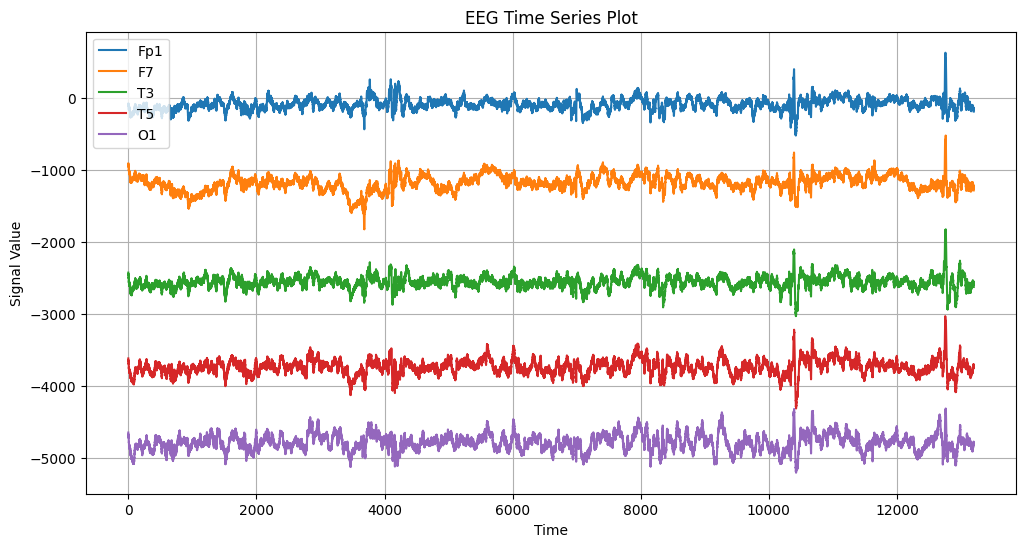

In [7]:
plot_time_series(df1, cons.LL)

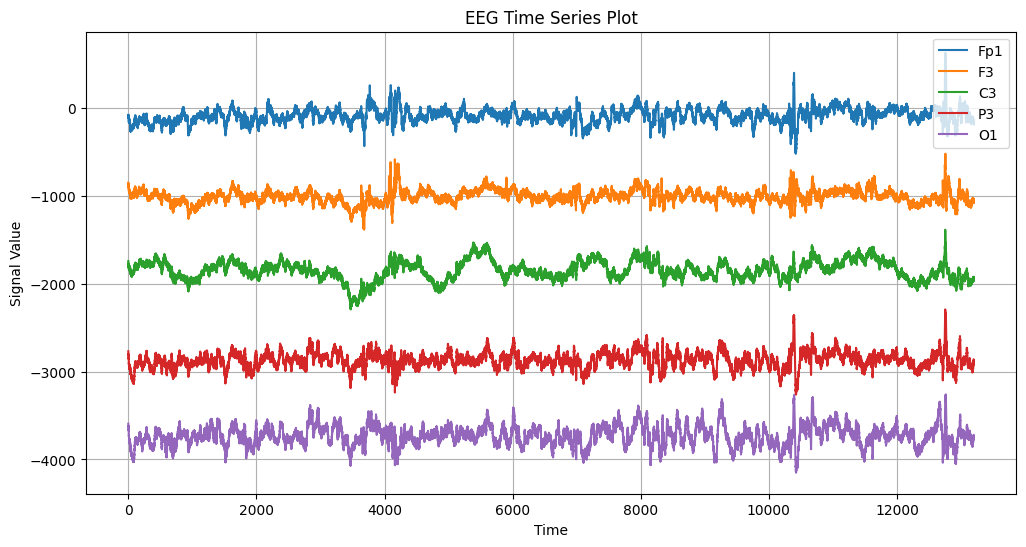

In [8]:
plot_time_series(df1, cons.LP)

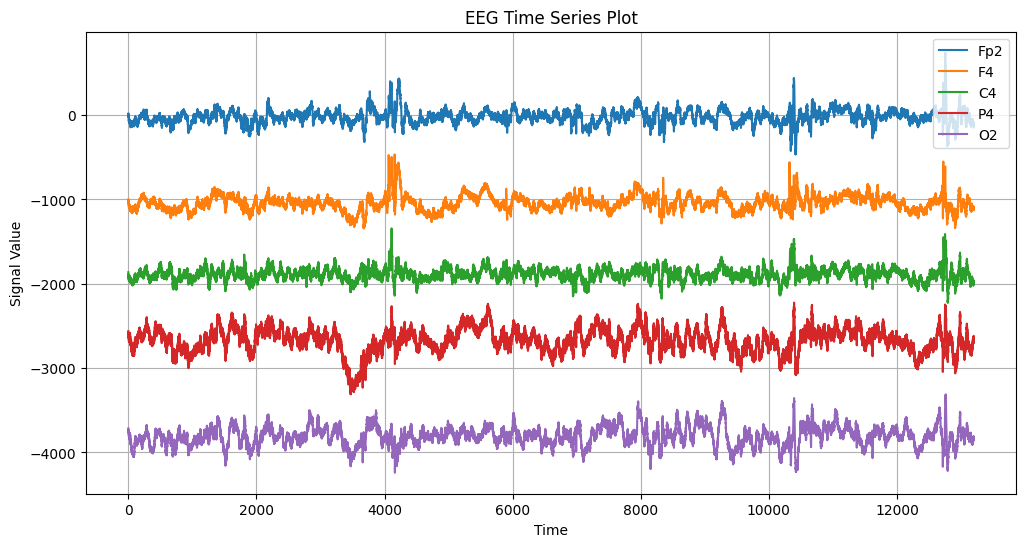

In [9]:
plot_time_series(df1, cons.RP)

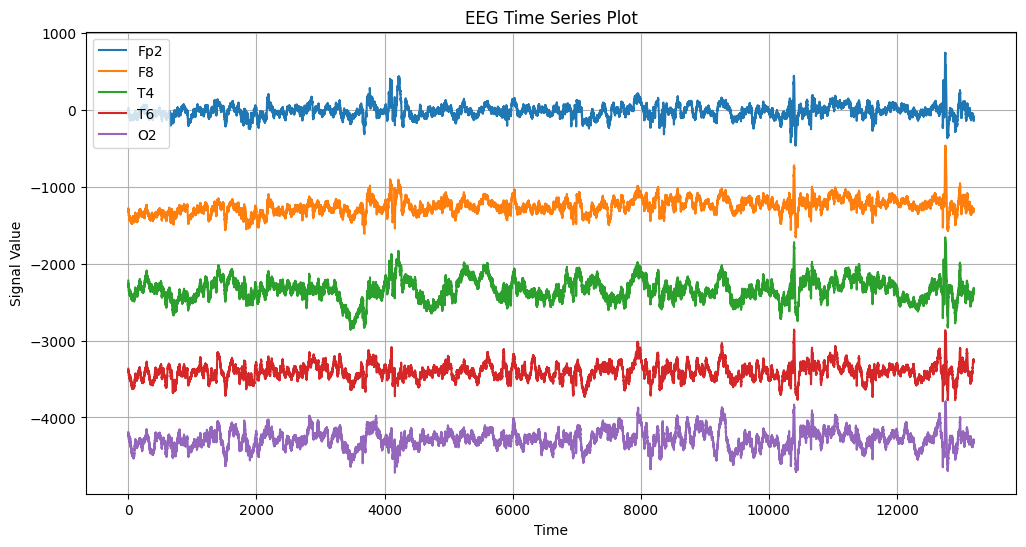

In [10]:
plot_time_series(df1, cons.RR)

From research, we noticed that the 4 features: 'Fp1', 'O1', 'Fp2', 'O2' are the most important for any classification.

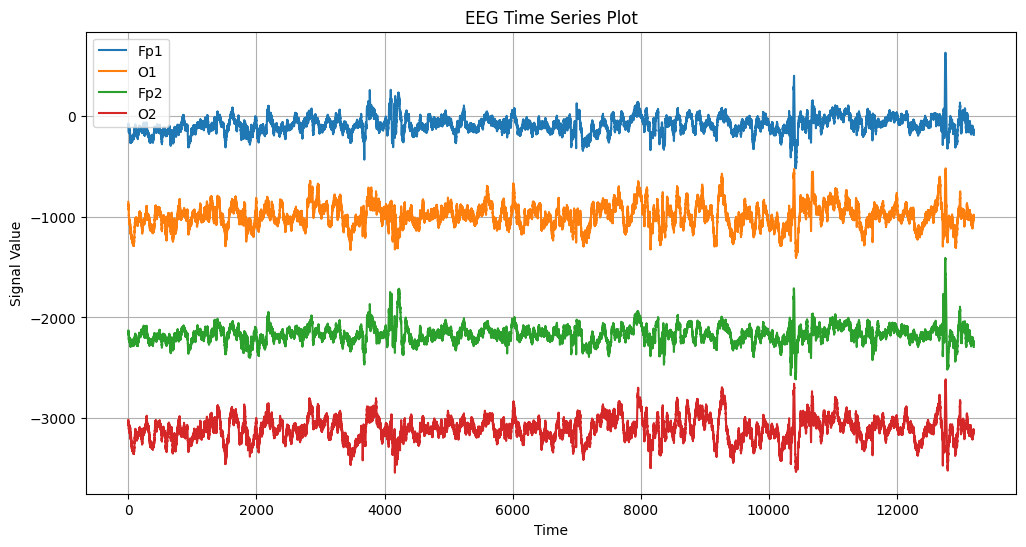

In [11]:
plot_time_series(df1, cons.IMPT_ELECTRODES)

#### Filters + Conversions
##### 1. Fourier Transformation: Discrete Cosine Transform (DCT)

In [88]:
print(df1.head())
display(df1.index)


          Fp1         F3         C3         P3          F7         T3     T5  \
0  -75.360001  86.379997  65.470001  62.580002  170.350006  92.370003  39.68   
1 -107.739998  53.139999  32.590000  21.950001  140.500000  59.070000   4.26   
2 -103.050003  46.330002  10.750000   9.150000  137.820007  50.950001  -3.50   
3  -75.099998  77.870003  40.150002  31.790001  166.630005  76.769997  17.99   
4  -97.919998  58.209999  27.330000   5.340000  144.080002  47.200001 -10.43   

          O1         Fz         Cz         Pz    Fp2     F4         C4  \
0  89.870003  18.260000 -28.440001 -15.190000  16.93  13.81 -42.160000   
1  53.310001 -18.490000 -63.270000 -52.110001 -13.23 -16.42 -80.430000   
2  45.070000 -20.879999 -66.629997 -69.750000  -9.20 -21.40 -93.089996   
3  67.650002  11.140000 -32.950001 -38.509998  14.77   9.79 -66.480003   
4  40.250000 -12.350000 -52.500000 -54.919998 -10.07  -8.04 -90.820000   

          P4          F8          T4         T6         O2           EKG  

RangeIndex(start=0, stop=13200, step=1)

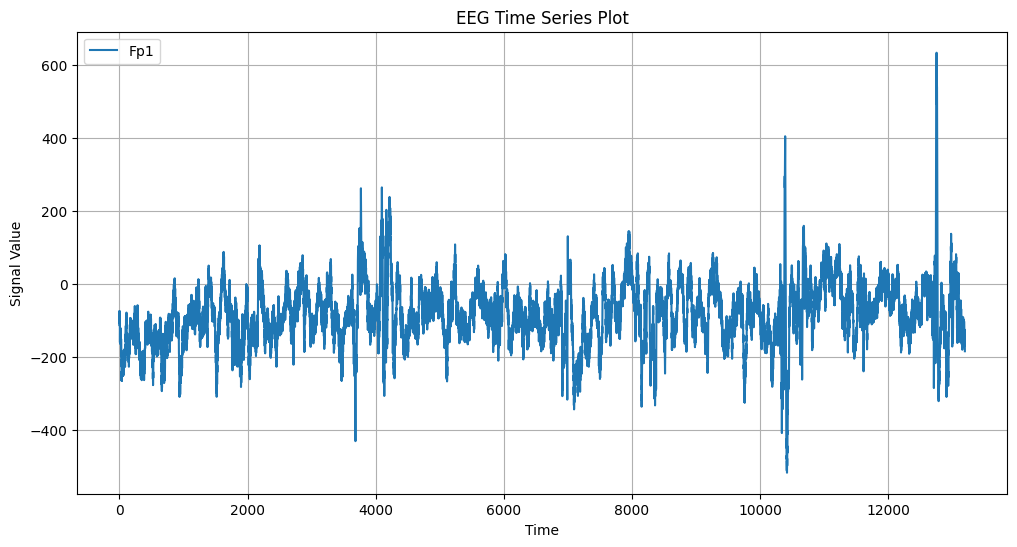

In [89]:
plot_time_series(df1, ['Fp1'])

In [90]:
def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

In [91]:
SAMPLE_RATE = 1320 # Hertz
DURATION = 10  # Seconds

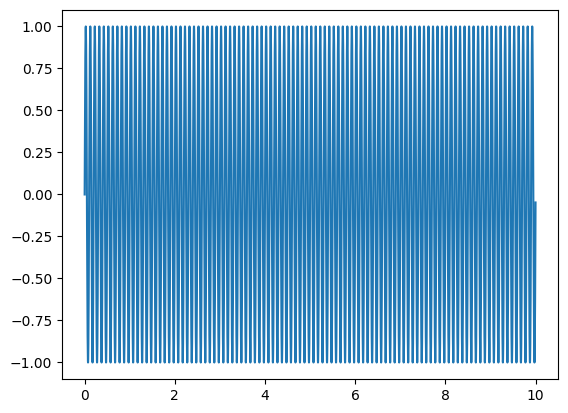

In [92]:
x, y = generate_sine_wave(10, SAMPLE_RATE, DURATION)
plt.plot(x, y)
plt.show()

In [94]:
# Adding Noise
# _, nice_tone = generate_sine_wave(400, cons.SAMPLE_RATE, cons.DURATION)
_, nice_tone = df1.index, df1['Fp1'].values.astype('float32')
_, noise_tone = generate_sine_wave(10, SAMPLE_RATE, DURATION)
noise_tone = noise_tone * 0.3

mixed_tone = nice_tone + noise_tone

#### Normalization

/var/folders/b3/nkthvkld0lx0lmw9_r5z6ckh0000gq/T/ipykernel_15282/3217216840.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


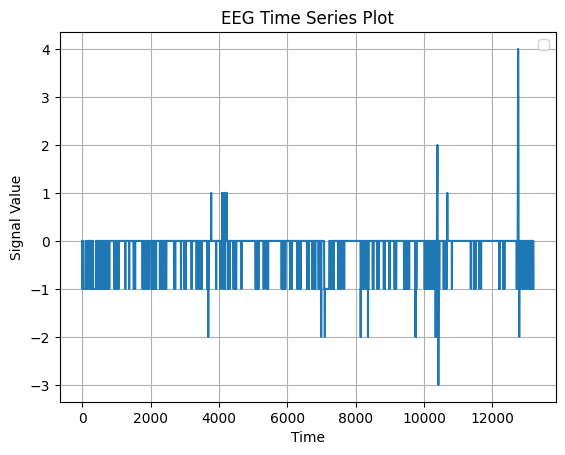

In [95]:
normalized_tone = np.int16((mixed_tone / mixed_tone.max()) * 4)

plt.plot(normalized_tone[:])
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.title('EEG Time Series Plot')
plt.legend()
plt.grid()
plt.show()


The range is going very large when converted. 
- Bad thing? (Outliers might be created). 
- Maybe good thing? (Easier to recognize now)

### Normalization matters alot. 

/var/folders/b3/nkthvkld0lx0lmw9_r5z6ckh0000gq/T/ipykernel_15282/895653902.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


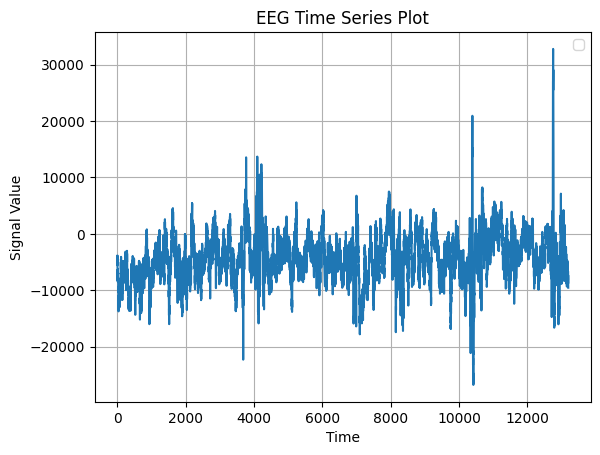

In [96]:
normalized_tone = np.int16((mixed_tone / mixed_tone.max()) * 32767)

plt.plot(normalized_tone[:])
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.title('EEG Time Series Plot')
plt.legend()
plt.grid()
plt.show()


2. Butter low pass filter

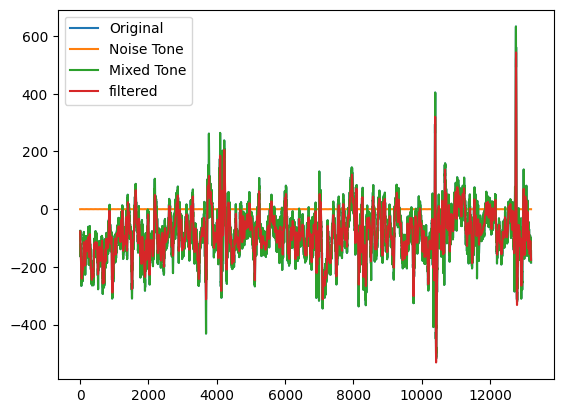

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


fs = 1000
plt.plot(df1.index, nice_tone, label='Original')

plt.plot(df1.index, noise_tone, label='Noise Tone')

mixed_tone = nice_tone + noise_tone
plt.plot(df1.index, mixed_tone, label='Mixed Tone')

fc = 30  # Cut-off frequency of the filter
w = fc / ( fs/ 2) # Normalize the frequency ## Used 1 as our frequencey before
b, a = signal.butter(5, w, 'low')
output = signal.filtfilt(b, a, mixed_tone)
plt.plot(df1.index, output, label='filtered')
plt.legend()
plt.show()

This reduces our range

### 3rd Method: Apply Different Transformations

Wavelet transform (WT)

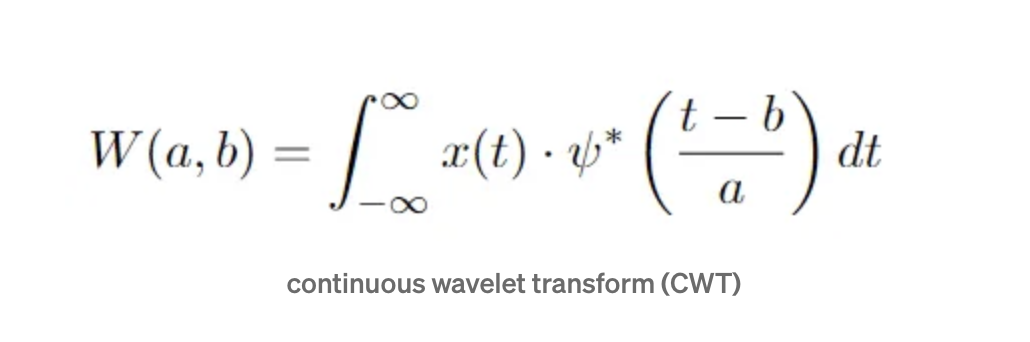

- ψ(t) is the mother wavelet, a function chosen based on the characteristics of the signal.
- a is the scaling factor (dilation), which controls the frequency.
- b is the translation factor, which controls the time shift.
- ψ is the complex conjugate of the wavelet function.

In [113]:
import pywt
def wavelet_transform(signal):
    scales = np.arange(1, 100)
    coefficients, frequencies = pywt.cwt(signal, scales, 'cmor')
    return coefficients, frequencies

/Users/Patron/Library/Python/3.9/lib/python/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


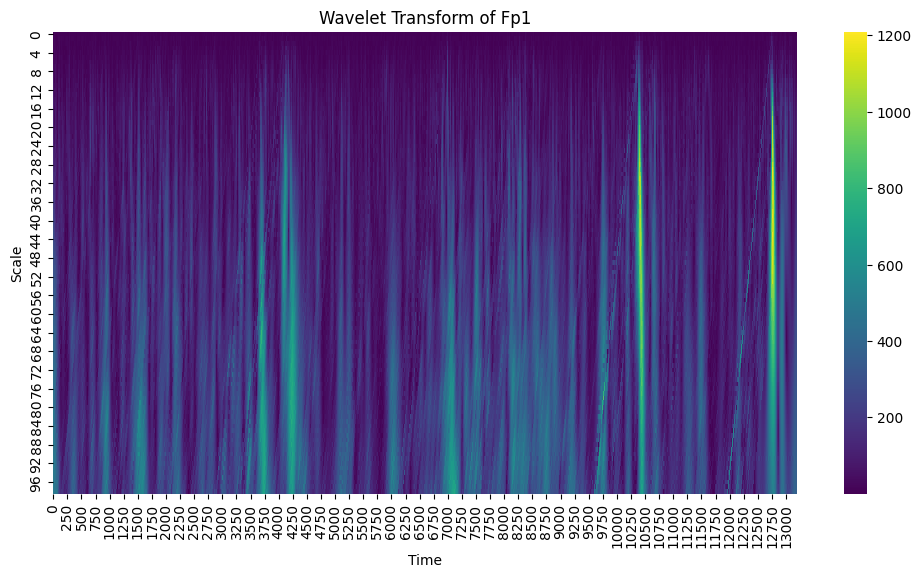

In [114]:
import seaborn as sns
signal = df1['Fp1'].values.astype('float32')
coefficients, frequencies = wavelet_transform(signal)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(np.abs(coefficients), cmap='viridis')
ax.set_aspect('auto')  # Adjust aspect ratio here
plt.xlabel('Time')
plt.ylabel('Scale')
plt.title('Wavelet Transform of Fp1')
plt.show()

This transformation can help us in identifying the eeg spikes in a much better way